In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle as pkl

import torch.autograd as autograd
import torch.nn as nn
import os
import gensim
import random
import enchant

import matplotlib.pyplot as plt
%matplotlib inline


with open("text_files/carroll-alice.txt", "r") as myfile:
    data=myfile.readlines()

aiw=' '.join(data).replace('\n',' ')
aiw2=''.join(aiw)
aiw3=aiw2.replace(',','').replace('.', ' .').replace('?',' ?').replace('!',' !').replace('[','').replace(']','').replace('-',' ').replace('(','').replace(')','')
aiw4=aiw3.split()
aiw5=[x.lower() for x in aiw4]
aiw_documents=[' '.join(aiw5)]


documents = ["Human machine interface for lab abc computer applications",
             "A survey of user opinion of computer system response time",
             "The EPS user interface management system",
             "System and human system engineering testing of EPS",
              "Relation of user perceived response time to error measurement",
              "The generation of random binary unordered trees",
              "The intersection graph of paths in trees",
              "Graph minors IV Widths of trees and well quasi ordering",
              "Graph minors A survey"]


def prep_doc(documents):
    texts = [[word for word in document.lower().split()]
         for document in documents]
    doc=' . '.join(documents)
    return [w.lower() for w in doc.split()]
    
def doc_clean(documents):
    doc1=prep_doc(documents)
    return [' '.join(doc1)]
    

size=100

docl=prep_doc(documents)
aiw_docl=prep_doc(aiw_documents)

sentence_lists=[sentence.split() for sentence in documents]
wl=[]
for s in sentence_lists:
    wl+=s
word_list=set(wl)

google_vec_file = '~/Downloads/GoogleNews-vectors-negative300.bin'
encoder = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

#w2v2=gensim.models.Word2Vec([aiw.split()], size=size, window=5, min_count=1, workers=4,sg=1)
w2v = gensim.models.Word2Vec([docl], size=size, window=5, min_count=1, workers=4,sg=1)
w2v2=gensim.models.Word2Vec([aiw_docl], size=size, window=5, min_count=1, workers=4,sg=1)
#w2v_bk=gensim.models.Word2Vec([bk3], size=size, window=5, min_count=1, workers=4,sg=1)

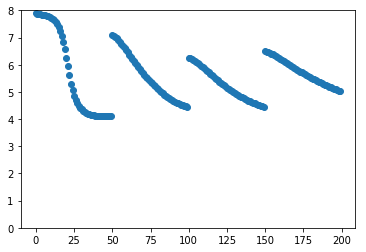

In [24]:
with open('data/losses') as f:
    losses=f.readlines()
    
losses_clean=[float(x) for x in losses[0].split(',')[:-1]]

plt.scatter(range(len(losses_clean)),losses_clean)
plt.ylim(0,8)
plt.show()

In [3]:
os.listdir('data/')

['losses',
 'messed_np_vecs.pkl',
 'sample_messages.pkl',
 'followers_short.pkl',
 'messed',
 'km.pkl',
 'short_messages1.pkl',
 'short_messages3.pkl',
 'short_messages2.pkl',
 'markov_data.pkl',
 'messages.pkl']

In [2]:
w2v_bk=gensim.models.Word2Vec([bk_new2], size=size, window=5, min_count=1, workers=4,sg=1)

NameError: name 'bk_new2' is not defined

In [176]:
bk_new2

['alexey',
 'fyodorovitch',
 'karamazov',
 'was',
 'the',
 'third',
 'son',
 'of',
 'fyodor',
 'pavlovitch',
 'karamazov',
 'a',
 'land',
 'owner',
 'well',
 'known',
 'in',
 'our',
 'district',
 'in',
 'his',
 'own',
 'day',
 'and',
 'still',
 'remembered',
 'among',
 'us',
 'owing',
 'to',
 'his',
 'gloomy',
 'and',
 'tragic',
 'death',
 'which',
 'happened',
 'thirteen',
 'years',
 'ago',
 'and',
 'which',
 'i',
 'shall',
 'describe',
 'in',
 'its',
 'proper',
 'place',
 '.',
 'for',
 'the',
 'present',
 'i',
 'will',
 'only',
 'say',
 'that',
 'this',
 '“landowner”—for',
 'so',
 'we',
 'used',
 'to',
 'call',
 'him',
 'although',
 'he',
 'hardly',
 'spent',
 'a',
 'day',
 'of',
 'his',
 'life',
 'on',
 'his',
 'own',
 'estate—was',
 'a',
 'strange',
 'type',
 'yet',
 'one',
 'pretty',
 'frequently',
 'to',
 'be',
 'met',
 'with',
 'a',
 'type',
 'abject',
 'and',
 'vicious',
 'and',
 'at',
 'the',
 'same',
 'time',
 'senseless',
 '.',
 'but',
 'he',
 'was',
 'one',
 'of',
 'those',

In [6]:
class CRAYBOT(nn.Module):
    
    documents = ["Human machine interface for lab abc computer applications",
             "A survey of user opinion of computer system response time",
             "The EPS user interface management system",
             "System and human system engineering testing of EPS",
              "Relation of user perceived response time to error measurement",
              "The generation of random binary unordered trees",
              "The intersection graph of paths in trees",
              "Graph minors IV Widths of trees and well quasi ordering",
              "Graph minors A survey"]


    def prep_doc(documents):
        texts = [[word for word in document.lower().split()]
             for document in documents]
        doc=' . '.join(documents)
        return [w.lower() for w in doc.split()]
    
    docl=prep_doc(documents)
      
    w2v = gensim.models.Word2Vec([docl], size=size, window=5, min_count=1, workers=4,sg=1)
    
    
    def __init__(self,encoder,sent_length=3,n_samples=70,hidden_size=50,max_iter=10,n_layers=1):
        
        super(CRAYBOT, self).__init__()
        
        self.sent_length=sent_length
        self.n_samples=n_samples
        self.size=size
        self.n_layers=n_layers
        self.hidden_size=hidden_size
        self.max_iter=max_iter
        self.hidden=self.init_hidden()
        self.lstm = nn.LSTM(size, hidden_size,n_layers,batch_first=True)
        self.layer=nn.Linear(hidden_size,len(encoder.wv.vocab))
        self.encoder=encoder
        self.dropout=nn.Dropout(p=0.1)
        self.doc=None
    
    def forward(self,x,hidden):
        lstm_out, self.hidden=self.lstm(x,hidden)
        return self.layer(lstm_out), self.hidden
        
        
    def _clean(self,doc):
        
        doc1=' . '.join(doc)
        return [w.lower() for w in doc1.split()]
        
        
    def word_to_idx(self,word):
        return list(self.encoder.wv.vocab).index(word)
        
        
    def index_to_word(self,n):
        return list(self.encoder.wv.vocab)[n]
        
    def _make_training_set(self,doc):
    
        #self.n_samples=n_samples
        
        self.doc=doc
        
        clean_doc=self._clean(doc)
        if self.encoder is None:       
            self.encoder=gensim.models.Word2Vec([clean_doc], size=self.size, window=5, min_count=1, workers=4,sg=1)
        sent_length=self.sent_length
        n_samples=self.n_samples
        
        doc_words=' . '.join(doc).split()

        
        doc_length=len(doc_words)
        training_examples=[]
        X_train=[]
        #y_train=[]
        y_labels=[]
        for i in range(n_samples):
            index=random.choice(range(doc_length-self.sent_length))
            x=doc_words[index:index+self.sent_length]
            y=doc_words[index+1:index+self.sent_length+1]
            next_word=self.word_to_idx(y[-1])
            x_tensor=torch.tensor([self.encoder.wv[w.lower()] for w in x])
            #y_tensor=torch.tensor([self.encoder.wv[w.lower()] for w in y])            
            X_train.append(x_tensor)
            #y_train.append(y_tensor)
            y_labels.append(next_word)

        Xt=torch.cat(X_train).view(self.n_samples,self.sent_length,-1)
        #yt=torch.cat(y_train).view(self.n_samples,self.sent_length,-1)
        tags=torch.tensor(y_labels)
        
        return Xt, tags

    def prep_string(self,doc):
        doc1=self._clean(doc)
        doc_words=' . '.join(doc).split()
        length=len(doc_words)
        X_example=[]
        x=doc_words[:]
        x_tensor=torch.tensor([self.encoder.wv[w.lower()] for w in x])
        X_example.append(x_tensor)
        return x_tensor.view(1,length,-1)
            
    
    def _sent_to_vec(self,sent):
        return torch.tensor([self.encoder.wv[w.lower()] for w in sent.split()])
        

    def init_hidden(self,batch_size=None):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        if batch_size is None:
            return (torch.zeros(self.n_layers, self.n_samples, self.hidden_size),
                    torch.zeros(self.n_layers, self.n_samples, self.hidden_size))
        else:
            return (torch.zeros(self.n_layers, batch_size, self.hidden_size),
                    torch.zeros(self.n_layers, batch_size, self.hidden_size))


In [ ]:
word_weights = output.squeeze().div(args.temperature).exp().cpu()
word_idx = torch.multinomial(word_weights, 1)[0]

In [18]:
torch.rand(3,2,1).div(4)

tensor([[[0.2010],
         [0.1695]],

        [[0.0765],
         [0.0697]],

        [[0.1403],
         [0.1692]]])

In [8]:
craycray=CRAYBOT(sent_length=5,n_samples=10000,hidden_size=50,n_layers=3,max_iter=150,encoder=w2v)

In [10]:
#craycray=CRAYBOT(sent_length=5,n_samples=10000,hidden_size=50,n_layers=3,max_iter=150,encoder=w2v_bk)
loss_function=nn.CrossEntropyLoss()

# loss_function = nn.MSELoss()
optimizer = optim.Adam(craycray.parameters(),lr=.001)

# initialize the hidden state.
#         hidden = (torch.randn(n_samples, n_samples, hidden_size),
#                   torch.randn(n_samples, n_samples, hidden_size))



Xt,tags=craycray._make_training_set(doc_clean([' '.join(documents)]))
losses=[]


for epoch in range(craycray.max_iter):


    craycray.hidden = craycray.init_hidden()
    hidden=craycray.hidden
    #print(craycray.hidden)
    optimizer.zero_grad()
    length=craycray.sent_length

    out, hidden = craycray(Xt,hidden)
    out2=out[:,length-1,:]
    #print(out2.div(arg))
    loss=loss_function(out2,tags)
    print(float(loss.detach().numpy()))
    losses.append(float(loss.detach().numpy()))
    loss.backward(retain_graph=True)
    optimizer.step()

3.749253511428833
3.745349884033203
3.741492986679077
3.7376277446746826
3.733736753463745
3.729830503463745
3.7256598472595215
3.7214531898498535
3.7170567512512207
3.712407112121582
3.707474946975708
3.702144145965576
3.696420431137085
3.690274715423584
3.6835484504699707
3.6760926246643066
3.6679956912994385
3.6591222286224365
3.649448871612549
3.638869047164917
3.6274125576019287
3.6152803897857666
3.602510929107666
3.5895774364471436
3.5770089626312256
3.5654044151306152
3.555506706237793
3.5477499961853027
3.5423121452331543
3.538835048675537
3.5362117290496826
3.5335640907287598
3.530086040496826
3.525700807571411
3.5206358432769775
3.515573024749756
3.5110204219818115
3.5072097778320312
3.5042145252227783
3.5020973682403564
3.5006637573242188
3.4998390674591064
3.499311685562134
3.4988136291503906
3.4983725547790527
3.4977362155914307
3.496880531311035
3.4958972930908203
3.4948058128356934
3.4935622215270996
3.4921936988830566
3.4908976554870605
3.4897749423980713
3.48868513107

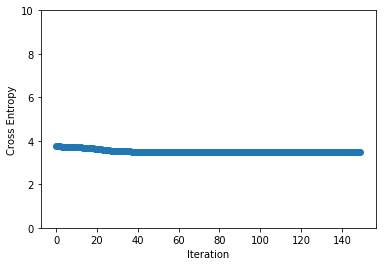

In [11]:
plt.scatter(range(len(losses)),losses)
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy')
plt.ylim(0,10)
plt.show()

In [170]:
bk_new=bk2.replace("\'",'').replace(';','').replace(',','')
bk_new2=[x.lower() for x in bk_new.split()]

In [8]:
with open("text_files/brothers_karamazov.txt", "r") as myfile:
    bk_data=myfile.readlines()
    

In [51]:
#'tHE' in list(encoder.wv.vocab)
# def get_examples(bk2):
#     words=bk2.split()
#     length=len(words)
#     for i in range(n_samples):
        
#         index=random.choice(range(length-sent_length))
#         x=doc_words[index:index+self.sent_length]
#         y=doc_words[index+1:index+self.sent_length+1]
    
    
    
    
bk3=[x for x in bk2.split()[:1000] if x in list(encoder.wv.vocab)]


/Users/williamcottrell72/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [105]:
bk2.split()

['Alexey',
 'Fyodorovitch',
 'Karamazov',
 'was',
 'the',
 'third',
 'son',
 'of',
 'Fyodor',
 'Pavlovitch',
 'Karamazov,',
 'a',
 'land',
 'owner',
 'well',
 'known',
 'in',
 'our',
 'district',
 'in',
 'his',
 'own',
 'day,',
 'and',
 'still',
 'remembered',
 'among',
 'us',
 'owing',
 'to',
 'his',
 'gloomy',
 'and',
 'tragic',
 'death,',
 'which',
 'happened',
 'thirteen',
 'years',
 'ago,',
 'and',
 'which',
 'I',
 'shall',
 'describe',
 'in',
 'its',
 'proper',
 'place',
 '.',
 'For',
 'the',
 'present',
 'I',
 'will',
 'only',
 'say',
 'that',
 'this',
 '“landowner”—for',
 'so',
 'we',
 'used',
 'to',
 'call',
 'him,',
 'although',
 'he',
 'hardly',
 'spent',
 'a',
 'day',
 'of',
 'his',
 'life',
 'on',
 'his',
 'own',
 'estate—was',
 'a',
 'strange',
 'type,',
 'yet',
 'one',
 'pretty',
 'frequently',
 'to',
 'be',
 'met',
 'with,',
 'a',
 'type',
 'abject',
 'and',
 'vicious',
 'and',
 'at',
 'the',
 'same',
 'time',
 'senseless',
 '.',
 'But',
 'he',
 'was',
 'one',
 'of',
 '

In [102]:
bk1=bk_data[185:]
bk2=''.join(bk1).replace('\n',' ').replace('.',' . ')


In [6]:
os.listdir('text_files/')

['blake-poems.txt',
 'carroll-alice.txt',
 'shakespeare-caesar.txt',
 'whitman-leaves.txt',
 'inspiration_quotes.txt',
 'milton-paradise.txt',
 'bible-kjv.txt',
 'ap_split.txt',
 'README',
 'austen-persuasion.txt',
 'melville-moby_dick.txt',
 'edgeworth-parents.txt',
 'bbc.zip',
 'cifar-10-python.tar.gz',
 'chesterton-thursday.txt',
 'burgess-busterbrown.txt',
 'chesterton-ball.txt',
 'austen-emma.txt',
 'chesterton-brown.txt',
 'shakespeare-hamlet.txt',
 'brothers_karamazov.txt',
 'austen-sense.txt',
 'shakespeare-macbeth.txt',
 'bryant-stories.txt',
 'spam.csv']

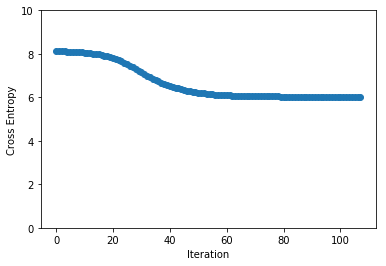

In [561]:
losses_low_lr=losses
plt.scatter(range(len(losses_low_lr)),losses_low_lr)
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy')
plt.ylim(0,10)
plt.show()

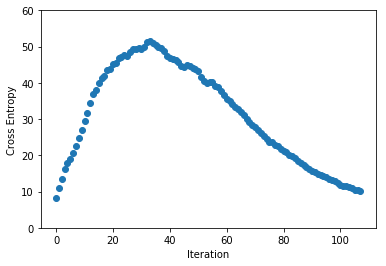

In [547]:
plt.scatter(range(len(losses_two_layers)),losses_two_layers)
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy')
plt.ylim(0,60)
plt.show()

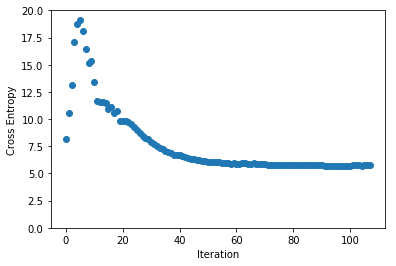

In [545]:
plt.scatter(range(len(losses_one_layer)),losses_one_layer)
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy')
plt.ylim(0,20)
plt.show()

In [182]:
sent=['alice and the']
def cray_word(sent):
    with torch.no_grad():
        x=craycray.prep_string(sent)
        hidden=craycray.init_hidden(batch_size=1)
        #Xt,yt=craycray._make_training_set(doc_clean(sent))
        out=craycray(x,hidden)
        out2=out[:,2,:]
        probs=F.softmax(out2).detach().numpy()[0]
    return craycray.index_to_word(np.random.choice(len(probs),p=probs))


def crayspeak(sent,n):
    with torch.no_grad():
        hidden=craycray.init_hidden(batch_size=1)
        length=len(sent[0].split())
        for i in range(n):
            x=craycray.prep_string(sent)
            out,hidden=craycray(x,hidden)
            out2=out[:,length-1,:]
            probs=F.softmax(out2).detach().numpy()[0]
            word=craycray.index_to_word(np.random.choice(len(probs),p=probs))
            sent=[sent[0]+' '+word]
    return sent

In [570]:
with open('messages.pkl','rb') as f:
    messages=pkl.load(f)

In [573]:
with open('messed_np_vecs.pkl','rb') as f:
    messed_np_vecs=pkl.load(f)
    
with open('km.pkl','rb') as f:
    km=pkl.load(f)
    
with open('messed','rb') as f:
    messed=pkl.load(f)

In [592]:
messed[['messages']][km.predict(messed_np_vecs)==2];

In [191]:
crayspeak(['a man recognizing that he was'],10)

/Users/williamcottrell72/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


['a man recognizing that he was korovkin . skepticism extremely believes fenya dumb and of find']

In [38]:
targets = prepare_sequence(tags, tag_to_ix)

In [48]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        #print(tag_scores)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

tensor([[-0.9777, -1.6790, -0.8272],
        [-0.9870, -1.6552, -0.8295],
        [-0.9692, -1.7208, -0.8171],
        [-0.8875, -1.5975, -0.9521],
        [-0.9219, -1.5191, -0.9588]])
tensor([[-0.8999, -0.5415, -4.4664],
        [-3.7880, -0.0283, -5.2542],
        [-4.4271, -3.2766, -0.0510],
        [-0.0275, -3.8455, -5.1518],
        [-2.9280, -0.0592, -5.5183]])
